In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_columns', 100)

In [2]:
xqrs = pd.read_csv('../to_csv/ml_data/xqrs_clean_mean.csv')
xqrs.head()

,Key,interval_start_time,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,vlf,lf_hf_ratio,csi,cvi,Modified_csi,sampen,sd1,sd2,ratio_sd2_sd1,label
0,train_01_tcp_ar_8643_s002_t005,0.0,665.457589,1.942364,1.532157,0.0,0.0,0.0,0.000000,1.532157,664.06250,3.90625,0.002302,0.002919,90.164234,90.352941,89.824561,0.253177,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
1,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
2,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
3,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
4,train_01_tcp_ar_8643_s002_t005,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0


In [37]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('%s(t-%d)' % (cols, i)) for cols in df.columns]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('%s(t)' % (cols)) for cols in df.columns]
		else:
			names += [('%s(t+%d)' % (cols, i)) for cols in df.columns]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [198]:
data = series_to_supervised(xqrs, 3, 1)
data

,Key(t-3),interval_start_time(t-3),mean_nni(t-3),sdnn(t-3),sdsd(t-3),nni_50(t-3),pnni_50(t-3),nni_20(t-3),pnni_20(t-3),rmssd(t-3),median_nni(t-3),range_nni(t-3),cvsd(t-3),cvnni(t-3),mean_hr(t-3),max_hr(t-3),min_hr(t-3),std_hr(t-3),lf(t-3),hf(t-3),vlf(t-3),lf_hf_ratio(t-3),csi(t-3),cvi(t-3),Modified_csi(t-3),sampen(t-3),sd1(t-3),sd2(t-3),ratio_sd2_sd1(t-3),label(t-3),Key(t-2),interval_start_time(t-2),mean_nni(t-2),sdnn(t-2),sdsd(t-2),nni_50(t-2),pnni_50(t-2),nni_20(t-2),pnni_20(t-2),rmssd(t-2),median_nni(t-2),range_nni(t-2),cvsd(t-2),cvnni(t-2),mean_hr(t-2),max_hr(t-2),min_hr(t-2),std_hr(t-2),lf(t-2),hf(t-2),...,median_nni(t-1),range_nni(t-1),cvsd(t-1),cvnni(t-1),mean_hr(t-1),max_hr(t-1),min_hr(t-1),std_hr(t-1),lf(t-1),hf(t-1),vlf(t-1),lf_hf_ratio(t-1),csi(t-1),cvi(t-1),Modified_csi(t-1),sampen(t-1),sd1(t-1),sd2(t-1),ratio_sd2_sd1(t-1),label(t-1),Key(t),interval_start_time(t),mean_nni(t),sdnn(t),sdsd(t),nni_50(t),pnni_50(t),nni_20(t),pnni_20(t),rmssd(t),median_nni(t),range_nni(t),cvsd(t),cvnni(t),mean_hr(t),max_hr(t),min_hr(t),std_hr(t),lf(t),hf(t),vlf(t),lf_hf_ratio(t),csi(t),cvi(t),Modified_csi(t),sampen(t),sd1(t),sd2(t),ratio_sd2_sd1(t),label(t)
3,train_01_tcp_ar_8643_s002_t005,0.0,665.457589,1.942364,1.532157,0.0,0.0,0.0,0.000000,1.532157,664.06250,3.90625,0.002302,0.002919,90.164234,90.352941,89.824561,2.531771e-01,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749e+00,46.079051,5.063510,...,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285e+00,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,3.320911e-01,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
4,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749e+00,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285e+00,46.079051,5.063510,...,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,3.320911e-01,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,8.859482e-01,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
5,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285e+00,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,3.320911e-01,46.079051,5.063510,...,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,8.859482e-01,46.079051,5.063510,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,50000.0,674.665179,3.884728,2.403846,0.0,0.0,0.0,0.000000,2.422553,675.78125,11.71875,0.003591,0.005758,88.935746,89.824561,88.275862,4.945259e-01,46.079051,5.063510,50.863572,22.475111,4.7326

In [86]:
%%time

d_xqrs = {k:xqrs[xqrs.Key == k] for k in xqrs.Key.unique()}

CPU times: user 27.5 s, sys: 5.84 ms, total: 27.5 s
Wall time: 27.5 s


In [87]:
%%time

big_df = pd.DataFrame()
for key in d_xqrs.keys():
    big_df = big_df.append(series_to_supervised(d_xqrs[key], 1, 1), ignore_index=True)

CPU times: user 1min 9s, sys: 35.2 s, total: 1min 44s
Wall time: 1min 44s


In [88]:
big_df.shape

(218223, 60)

In [93]:
big_df.drop(['Key(t)', 'label(t-1)'], axis=1, inplace=True)

In [94]:
train = big_df[big_df['Key(t-1)'].str.match('train')]
dev = big_df[big_df['Key(t-1)'].str.match('dev')]

In [95]:
big_df.shape[0] - train.shape[0] - dev.shape[0]

0

In [96]:
train.head()

,Key(t-1),interval_start_time(t-1),mean_nni(t-1),sdnn(t-1),sdsd(t-1),nni_50(t-1),pnni_50(t-1),nni_20(t-1),pnni_20(t-1),rmssd(t-1),median_nni(t-1),range_nni(t-1),cvsd(t-1),cvnni(t-1),mean_hr(t-1),max_hr(t-1),min_hr(t-1),std_hr(t-1),lf(t-1),hf(t-1),vlf(t-1),lf_hf_ratio(t-1),csi(t-1),cvi(t-1),Modified_csi(t-1),sampen(t-1),sd1(t-1),sd2(t-1),ratio_sd2_sd1(t-1),interval_start_time(t),mean_nni(t),sdnn(t),sdsd(t),nni_50(t),pnni_50(t),nni_20(t),pnni_20(t),rmssd(t),median_nni(t),range_nni(t),cvsd(t),cvnni(t),mean_hr(t),max_hr(t),min_hr(t),std_hr(t),lf(t),hf(t),vlf(t),lf_hf_ratio(t),csi(t),cvi(t),Modified_csi(t),sampen(t),sd1(t),sd2(t),ratio_sd2_sd1(t),label(t)
0,train_01_tcp_ar_8643_s002_t005,0.0,665.457589,1.942364,1.532157,0.0,0.0,0.0,0.000000,1.532157,664.06250,3.90625,0.002302,0.002919,90.164234,90.352941,89.824561,0.253177,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
1,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
2,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
3,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0
4,train_01_tcp_ar_8643_s002_t005,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,50000.0,674.665179,3.884728,2.403846,0.0,0.0,0.0,0.000000,2.422553,675.78125,11.71875,0.003591,0.005758,88.935746,89.824561,88.275862,0.494526,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0


In [146]:
X_train = train.iloc[:,2:-1]
y_train = train.iloc[:,-1:]

X_test = dev.iloc[:,2:-1]
y_test = dev.iloc[:,-1:]

In [147]:
y_train['label(t)'] = y_train['label(t)'].apply(lambda x: 0 if x < 0.5 else 1).astype(int)
y_test['label(t)'] = y_test['label(t)'].apply(lambda x: 0 if x < 0.5 else 1).astype(int)

In [149]:
y_train['label(t)'].value_counts()

0    168301
1      9258
Name: label(t), dtype: int64

In [150]:
y_test['label(t)'].value_counts()

0    36837
1     3827
Name: label(t), dtype: int64

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

In [152]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [153]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [154]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [155]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [156]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['mean_nni(t-1)', 'sdnn(t-1)', 'sdsd(t-1)', 'nni_50(t-1)',
       'pnni_50(t-1)', 'nni_20(t-1)', 'pnni_20(t-1)', 'rmssd(t-1)',
       'median_nni(t-1)', 'range_nni(t-1)', 'cvsd(t-1)', 'cvnni(t-1)',
       'mean_hr(t-1)', 'max_hr(t-1)', 'min_hr(t-1)', 'std_hr(t-1)...
       'sdnn(t)', 'sdsd(t)', 'nni_50(t)', 'pnni_50(t)', 'nni_20(t)',
       'pnni_20(t)', 'rmssd(t)', 'median_nni(t)', 'range_nni(t)', 'cvsd(t)',
       'cvnni(t)', 'mean_hr(t)', 'max_hr(t)', 'min_hr(t)', 'std_hr(t)',
       'lf(t)', 'hf(t)', 'vlf(t)', 'lf_hf_ratio(t)', 'csi(t)', 'cvi(t)',
       'Modified_csi(t)', 'sampen(t)', 'sd1(t)', 'sd2(t)', 'ratio_sd2_sd1(t)'],
      dtype='object'))])),
                ('classi

In [157]:
y_pred_train = rf.predict(X_train)
rf.score(X_train, y_train)

0.9999831042076155

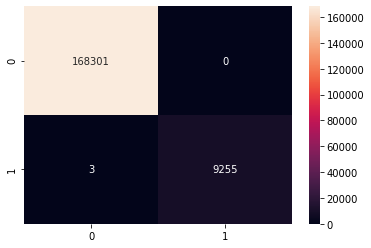

In [158]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d')

In [159]:
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)

0.9030838087743459

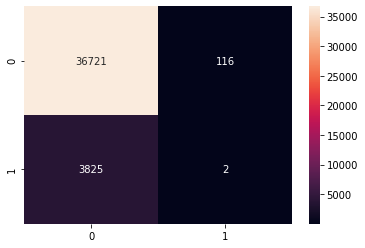

In [160]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [161]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
    
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    print(cm)

KNeighborsClassifier(n_neighbors=3)
model score: 0.884
[[35854   983]
 [ 3734    93]]
DecisionTreeClassifier()
model score: 0.858
[[34606  2231]
 [ 3532   295]]
RandomForestClassifier()
model score: 0.903
[[36727   110]
 [ 3826     1]]
AdaBoostClassifier()
model score: 0.907
[[36786    51]
 [ 3741    86]]
GradientBoostingClassifier()
model score: 0.905
[[36783    54]
 [ 3823     4]]


# Grid search on DecisionTree

In [163]:
from sklearn.model_selection import GridSearchCV

In [188]:
clf = DecisionTreeClassifier()

params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 10, 2).tolist(),
    'min_samples_split': np.arange(2, 6, 2).tolist(),
    'min_samples_leaf': np.arange(1, 6, 2).tolist(),
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [{0:0.2, 1:0.8}, {0:0.4, 1:0.6}]
}

grid = GridSearchCV(clf, params, scoring='f1', n_jobs=-1, verbose=1)

In [189]:
[np.arange(1, 6, 2).tolist()]

[[1, 3, 5]]

In [190]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.4min finished


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.2, 1: 0.8}, {0: 0.4, 1: 0.6}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4],
                         'splitter': ['best', 'random']},
             scoring='f1', verbose=1)

In [191]:
grid.best_params_

{'class_weight': {0: 0.2, 1: 0.8},
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'splitter': 'best'}

In [193]:
grid.best_score_

0.1078510633394558

In [195]:
y_pred_grid = grid.best_estimator_.predict(X_test)

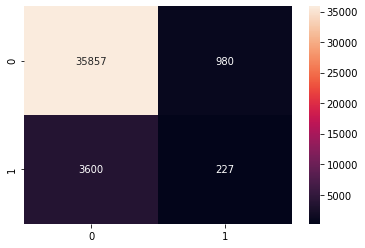

In [196]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_grid)

sns.heatmap(cm, annot=True, fmt='d')

# Dataset retardé de 30 sec

In [199]:
%%time

big_df = pd.DataFrame()
for key in d_xqrs.keys():
    big_df = big_df.append(series_to_supervised(d_xqrs[key], 3, 1), ignore_index=True)

CPU times: user 2min 13s, sys: 1min 9s, total: 3min 23s
Wall time: 3min 23s


In [200]:
big_df.head()

,Key(t-3),interval_start_time(t-3),mean_nni(t-3),sdnn(t-3),sdsd(t-3),nni_50(t-3),pnni_50(t-3),nni_20(t-3),pnni_20(t-3),rmssd(t-3),median_nni(t-3),range_nni(t-3),cvsd(t-3),cvnni(t-3),mean_hr(t-3),max_hr(t-3),min_hr(t-3),std_hr(t-3),lf(t-3),hf(t-3),vlf(t-3),lf_hf_ratio(t-3),csi(t-3),cvi(t-3),Modified_csi(t-3),sampen(t-3),sd1(t-3),sd2(t-3),ratio_sd2_sd1(t-3),label(t-3),Key(t-2),interval_start_time(t-2),mean_nni(t-2),sdnn(t-2),sdsd(t-2),nni_50(t-2),pnni_50(t-2),nni_20(t-2),pnni_20(t-2),rmssd(t-2),median_nni(t-2),range_nni(t-2),cvsd(t-2),cvnni(t-2),mean_hr(t-2),max_hr(t-2),min_hr(t-2),std_hr(t-2),lf(t-2),hf(t-2),...,median_nni(t-1),range_nni(t-1),cvsd(t-1),cvnni(t-1),mean_hr(t-1),max_hr(t-1),min_hr(t-1),std_hr(t-1),lf(t-1),hf(t-1),vlf(t-1),lf_hf_ratio(t-1),csi(t-1),cvi(t-1),Modified_csi(t-1),sampen(t-1),sd1(t-1),sd2(t-1),ratio_sd2_sd1(t-1),label(t-1),Key(t),interval_start_time(t),mean_nni(t),sdnn(t),sdsd(t),nni_50(t),pnni_50(t),nni_20(t),pnni_20(t),rmssd(t),median_nni(t),range_nni(t),cvsd(t),cvnni(t),mean_hr(t),max_hr(t),min_hr(t),std_hr(t),lf(t),hf(t),vlf(t),lf_hf_ratio(t),csi(t),cvi(t),Modified_csi(t),sampen(t),sd1(t),sd2(t),ratio_sd2_sd1(t),label(t)
0,train_01_tcp_ar_8643_s002_t005,0.0,665.457589,1.942364,1.532157,0.0,0.0,0.0,0.000000,1.532157,664.06250,3.90625,0.002302,0.002919,90.164234,90.352941,89.824561,0.253177,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,...,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
1,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,...,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
2,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,...,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,0.0,train_01_tcp_ar_8643_s002_t005,50000.0,674.665179,3.884728,2.403846,0.0,0.0,0.0,0.000000,2.422553,675.78125,11.71875,0.003591,0.005758,88.935746,89.824561,88.275862,0.494526,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
3,train_

In [201]:
big_df.drop(['Key(t-2)', 'Key(t-1)', 'Key(t)', 'label(t-1)', 'label(t-2)', 'label(t-3)', 'interval_start_time(t-3)', 'interval_start_time(t-2)', 'interval_start_time(t-1)', 'interval_start_time(t)'], axis=1, inplace=True)

In [203]:
train = big_df[big_df['Key(t-3)'].str.match('train')]
dev = big_df[big_df['Key(t-3)'].str.match('dev')]

In [204]:
X_train = train.iloc[:,2:-1]
y_train = train.iloc[:,-1:]

X_test = dev.iloc[:,2:-1]
y_test = dev.iloc[:,-1:]

In [205]:
y_train['label(t)'] = y_train['label(t)'].apply(lambda x: 0 if x < 0.5 else 1).astype(int)
y_test['label(t)'] = y_test['label(t)'].apply(lambda x: 0 if x < 0.5 else 1).astype(int)

In [206]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [207]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [208]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [209]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_jobs=-1))])

In [210]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['mean_nni(t-3)', 'sdnn(t-3)', 'sdsd(t-3)', 'nni_50(t-3)',
       'pnni_50(t-3)', 'nni_20(t-3)', 'pnni_20(t-3)', 'rmssd(t-3)',
       'median_nni(t-3)', 'range_nni(t-3)',
       ...
       'hf(t)', 'vlf(t)', 'lf_hf_ratio(t)', 'csi(t)', 'cvi(t)',
       'Modified_csi(t)', 'sampen(t)', 'sd1(t)', 'sd2(t)', 'ratio_sd2_sd1(t)'],
      dtype='object', length=111))])),
                ('classifier', RandomForestClassifier(n_jobs=-1))])

In [211]:
y_pred_train = rf.predict(X_train)
rf.score(X_train, y_train)

0.9999709749513831

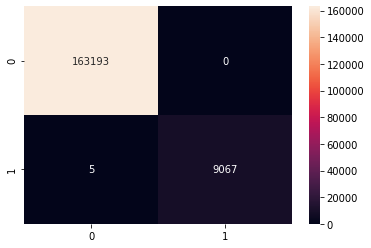

In [212]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d')

In [213]:
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)

0.9014763330120238

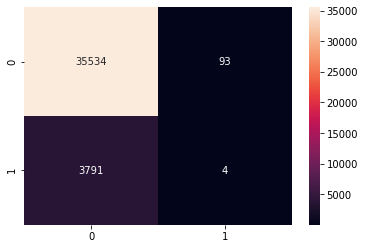

In [214]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [215]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs=-1),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
    
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    print(cm)

KNeighborsClassifier(n_neighbors=3)
model score: 0.883
[[34700   927]
 [ 3681   114]]
DecisionTreeClassifier()
model score: 0.855
[[33476  2151]
 [ 3564   231]]
RandomForestClassifier(n_jobs=-1)
model score: 0.901
[[35533    94]
 [ 3793     2]]
AdaBoostClassifier()
model score: 0.904
[[35583    44]
 [ 3735    60]]
GradientBoostingClassifier()
model score: 0.903
[[35584    43]
 [ 3794     1]]


In [217]:
big_df.head()

,Key(t-3),interval_start_time(t-3),mean_nni(t-3),sdnn(t-3),sdsd(t-3),nni_50(t-3),pnni_50(t-3),nni_20(t-3),pnni_20(t-3),rmssd(t-3),median_nni(t-3),range_nni(t-3),cvsd(t-3),cvnni(t-3),mean_hr(t-3),max_hr(t-3),min_hr(t-3),std_hr(t-3),lf(t-3),hf(t-3),vlf(t-3),lf_hf_ratio(t-3),csi(t-3),cvi(t-3),Modified_csi(t-3),sampen(t-3),sd1(t-3),sd2(t-3),ratio_sd2_sd1(t-3),interval_start_time(t-2),mean_nni(t-2),sdnn(t-2),sdsd(t-2),nni_50(t-2),pnni_50(t-2),nni_20(t-2),pnni_20(t-2),rmssd(t-2),median_nni(t-2),range_nni(t-2),cvsd(t-2),cvnni(t-2),mean_hr(t-2),max_hr(t-2),min_hr(t-2),std_hr(t-2),lf(t-2),hf(t-2),vlf(t-2),lf_hf_ratio(t-2),...,pnni_20(t-1),rmssd(t-1),median_nni(t-1),range_nni(t-1),cvsd(t-1),cvnni(t-1),mean_hr(t-1),max_hr(t-1),min_hr(t-1),std_hr(t-1),lf(t-1),hf(t-1),vlf(t-1),lf_hf_ratio(t-1),csi(t-1),cvi(t-1),Modified_csi(t-1),sampen(t-1),sd1(t-1),sd2(t-1),ratio_sd2_sd1(t-1),interval_start_time(t),mean_nni(t),sdnn(t),sdsd(t),nni_50(t),pnni_50(t),nni_20(t),pnni_20(t),rmssd(t),median_nni(t),range_nni(t),cvsd(t),cvnni(t),mean_hr(t),max_hr(t),min_hr(t),std_hr(t),lf(t),hf(t),vlf(t),lf_hf_ratio(t),csi(t),cvi(t),Modified_csi(t),sampen(t),sd1(t),sd2(t),ratio_sd2_sd1(t),label(t)
0,train_01_tcp_ar_8643_s002_t005,0.0,665.457589,1.942364,1.532157,0.0,0.0,0.0,0.000000,1.532157,664.06250,3.90625,0.002302,0.002919,90.164234,90.352941,89.824561,0.253177,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,...,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
1,train_01_tcp_ar_8643_s002_t005,10000.0,672.135417,11.762073,11.504201,0.0,0.0,1.0,6.666667,11.718750,675.78125,46.87500,0.017435,0.017500,89.294479,94.814815,88.275862,1.582749,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,...,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,40000.0,663.330078,6.723404,2.240189,0.0,0.0,0.0,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
2,train_01_tcp_ar_8643_s002_t005,20000.0,657.031250,10.460751,9.002380,0.0,0.0,1.0,6.666667,9.511195,660.15625,42.96875,0.014476,0.015921,91.342484,96.603774,90.352941,1.471285,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1.808242,660.15625,7.81250,0.002737,0.003784,90.817138,91.428571,90.352941,0.332091,46.079051,5.06351,50.863572,22.475111,...,0.000000,2.470529,664.06250,15.62500,0.003724,0.010136,90.461400,91.428571,89.302326,0.885948,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.7016,0.517062,6.555356,19.970406,4.732654,50000.0,674.665179,3.884728,2.403846,0.0,0.0,0.0,0.000000,2.422553,675.78125,11.71875,0.003591,0.005758,88.935746,89.824561,88.275862,0.494526,46.079051,5.06351,50.863572,22.475111,4.732654,3.087285,354.701600,0.517062,6.555356,19.970406,4.732654,0.0
3,train_01_tcp_ar_8643_s002_t005,30000.0,660.677083,2.499767,1.786586,0.0,0.0,0.0,0.000000,1

In [221]:
big_df.to_csv('../to_csv/late_data/xqrs_3_late.csv', index=False)